In [238]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../../..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [239]:
import os
from datetime import datetime as dt
import numpy as np
import pandas as pd
import scipy.stats as scist

import matplotlib.pyplot as plt

import tensorflow as tf

from tqdm.notebook import tqdm, trange

import yfinance as yf
import arch
import pmdarima

from analysis.options.pricing.phat import Phat
from analysis.options.pricing.bootstrap.numpy import dbl_bs
from analysis.options.pricing.learn.utils import DataSplit
from analysis.options.pricing.learn.phatnet import PhatNet, PhatLoss, PhatMetric
from analysis.options.pricing.utils import PriceSim
from analysis.options.pricing.garch import Garchcaster

import seaborn as sns; sns.set(style = 'whitegrid')

## PHAT-ARCH ##

I'm sure you are wondering what all this has to do with that fat tails. 

We have seen evidence that equity price returns are fat-tailed and that the left tail is likely fatter than the right tail (attributed to various phenomena). 
https://www.diva-portal.org/smash/get/diva2:417608/FULLTEXT01.pdf

GARCH models have thus been adjusted in an attempt to capture this phenomenon. For instance, Asymmetric Power ARCH, APARCH, attempts to capture excess left tail risk by introducing a differencing of innovations against their absolute value and allowing for variability in the power of the deviations, introducing skewness (or at least moving in the direction of the third moment). 

https://www.semanticscholar.org/paper/Estimating-and-forecasting-volatility-of-stock-and-Peters/f445493c46b3b4d52e958f69d502ccf8f03d51c3


These types of GARCH approaches do not address the key assumption that the innovations (the random error term) are standard normally distributed. As we've discussed ad nauseum, in all likelihood, financial returns have fat tails and so after stripping out serial and error correlation in both the mean and variance, we are left with residuals that STILL exhibit fat tails.

Other fat-tail distributions have been substituted in GARCH models: [Student's T, skewed Student's T, Extreme Value Distrubtion](https://www.semanticscholar.org/paper/Estimating-and-forecasting-volatility-of-stock-and-Peters/f445493c46b3b4d52e958f69d502ccf8f03d51c3), all of which, as we've shown previously, are less ideal than the Pareto in capturing tail propertiers. The Pareto, of course, is single-tailed so its use has typically been restricted to VaR estimation. Some approaches have used a two-tailed Pareto with a non-parametric normal density estimation in the body.

The Phat distribution improves upon this technique by introducing a fully continuous double Pareto with estimable statistical properties throughout.

And so we will look to incorporate the Phat distribution into a GARCH forecast.

## Approach ##

The generally understood requirement for the distribution of innovations is simply:

$$E[e^2_{t+1}|F_t]=1$$

So, to introduce Phat innovations into the GARCH forecast:

1. Fit a standard ARMA(2,2)-GARCH(1,1) process to S&P 500 index daily returns.

2. Fit the Phat distribution to the standardized residuals of this process using the Hill Double Bootstrap and `PhatNet`.

3. Generate an ARMA-GARCH forecast using our `Garchcast`, using standarized draws from the Phat distribution found in 2.

This approach is similar to that used by [Danielsson and Devries (1997)](https://papers.tinbergen.nl/98017.pdf) and outlined in [this tutorial](https://www.mathworks.com/help/econ/using-extreme-value-theory-and-copulas-to-evaluate-market-risk.html) with the key difference again being the use of a fully-parameterized distribution.

### A Note on Scaling ###

As shown previously, GARCH models tend to fit daily equity returns best when scaled in percentage terms (i.e. factor of 100x). Meanwhile, the `PhatNet` custom loss function performs appropriately on smaller scales. We have found a 10x factor of the simple returns for the S&P500 index to be an appropriate scale for `PhatNet`.

***GREAT CARE SHOULD BE USED IN TRANSLATING BETWEEN THE TWO MODELS AND THEIR SCALES***

### Forecasting Time Series with Pareto Hybrids ###

#### Generate ARMA-GARCH Residuals ####

In [3]:
sp = yf.download('^GSPC')
sp_ret = sp.Close.pct_change().dropna()*100
# sp_ret = sp_ret[sp_ret.index >= '1950-01-01']

[*********************100%***********************]  1 of 1 completed


In [4]:
from statsmodels.tsa.stattools import adfuller

adf, p_value, _, _, crit, _ = adfuller(sp_ret, regression='ct')
adf, crit['1%'], p_value

(-22.578358017226346, -3.959156111408333, 0.0)

In [5]:
arma22 = pmdarima.ARIMA((2,0,2)).fit(sp_ret)
arma22_resids = pd.Series(arma22.resid(), index=sp_ret.index)

We will fit the ARMA(2,2) residuals to an ARCH(1,1) across 7 windows of fixed length.

In [6]:
arma22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                23496
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -37567.723
Date:                Sat, 17 Jul 2021   AIC                          75147.446
Time:                        04:21:21   BIC                          75195.834
Sample:                             0   HQIC                         75163.155
                              - 23496                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0570      0.015      3.852      0.000       0.028       0.086
ar.L1         -0.0213      0.033     -0.636      0.525      -0.087       0.044
ar.L2         -0.8506      0.035    -24.452      0.000      -0.919      -0.782
ma.L1          0.0171      0.035      0.496      0.620      -0.051       0.085
ma.L2          0.8367      0.036     23.303      0.000       0.766       0.907
sigma2         1.4328      0.004    337.623      0.000       1.424       1.441
===================================================================================
Ljung-Box (L1) (Q):                   2.36   Jarque-Bera (JB):            302706.65
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
n_windows = 7
window = int(arma22_resids.size / n_windows)
windex = np.array([np.arange(i*window, (i+1)*window) for i in range(n_windows)])

In [8]:
garch_resids = np.zeros((n_windows, window))
for i in trange(n_windows):
    arch11 = arch.arch_model(arma22_resids[windex[i]], p=1, q=1).fit(disp='off')
    garch_resids[i] = arch11.std_resid

  0%|          | 0/7 [00:00<?, ?it/s]

#### Fit Residuals to Phat Distribution ####

We flatten the residuals and reduce the scale by 10x, then estimate both the left and right tails via the Hill Double Bootstrap.

In [9]:
resids_for_phat = garch_resids.flatten() / 10
data = DataSplit(np.zeros(garch_resids.size), resids_for_phat)

left = resids_for_phat[resids_for_phat < resids_for_phat.mean()]
left = np.sort(-left)[::-1]

right = resids_for_phat[resids_for_phat > resids_for_phat.mean()]
right = np.sort(right)[::-1]

np.seterr(all='ignore')
shl = np.zeros(10)
shr = np.zeros(10)
for i in trange(10):
    shl[i] = dbl_bs(left, t=.5, r=500, style='hill', A_type='dani')
    shr[i] = dbl_bs(right, t=.5, r=500, style='hill', A_type='dani')

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
shl.mean(), shr.mean()

(0.2527262346573344, 0.20521019255866055)

In [11]:
nnet = PhatNet(neurons=1)

metrics = [
    PhatMetric('shape_left'),
    PhatMetric('shape_right'),
    PhatMetric('mean_left'),
    PhatMetric('std_left'),  
]
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
nnet.compile(loss=PhatLoss(shl.mean(),shr.mean()), optimizer=optimizer, metrics=metrics)

history = nnet.fit(
    data.train, 
    epochs=100,
    validation_data=data.test,
    logdir=f"logs/garch_strip_{dt.now().strftime('%Y-%m-%d-%H-%M')}"
)

Epoch 1/100
595/595 [==============================] - 5s 4ms/step - loss: 0.3555 - shape_left: 0.7651 - shape_right: 0.7440 - mean_left: 0.0173 - std_left: 0.3481 - val_loss: 0.1833 - val_shape_left: 0.7653 - val_shape_right: 0.7441 - val_mean_left: 0.0173 - val_std_left: 0.3475
Epoch 2/100
595/595 [==============================] - 2s 3ms/step - loss: -0.0075 - shape_left: 0.6356 - shape_right: 0.6066 - mean_left: -7.6270e-04 - std_left: 0.1150 - val_loss: -0.2116 - val_shape_left: 0.6348 - val_shape_right: 0.6058 - val_mean_left: -6.5483e-04 - val_std_left: 0.1148
Epoch 3/100
595/595 [==============================] - 1s 2ms/step - loss: -0.5766 - shape_left: 0.2559 - shape_right: 0.2206 - mean_left: -0.0043 - std_left: 0.0411 - val_loss: -0.7925 - val_shape_left: 0.2558 - val_shape_right: 0.2204 - val_mean_left: -0.0039 - val_std_left: 0.0411
Epoch 4/100
595/595 [==============================] - 2s 3ms/step - loss: -0.8325 - shape_left: 0.2461 - shape_right: 0.2004 - mean_left: -0

#### Some More Notes on Scaling ####

We "descaled" our garch residuals in order to fit the Phat distribution. To translate back to the garch residuals, we must rescale by a factor of 10. We found that scaling both `mu` and `std` parameters found in the Garch fit leads to the exact same distribution as scaling a sample of random draw by 10.

In [12]:
mu, std, l, r = nnet.predicted_params(return_type='values')
phat1 = Phat(None, mu, std, l, r)
phat2 = Phat(None, mu*10, std*10, l, r)

In [13]:
n = 10000000
rv1 = phat1.rvs(n)*10
rv2 = phat2.rvs(n)

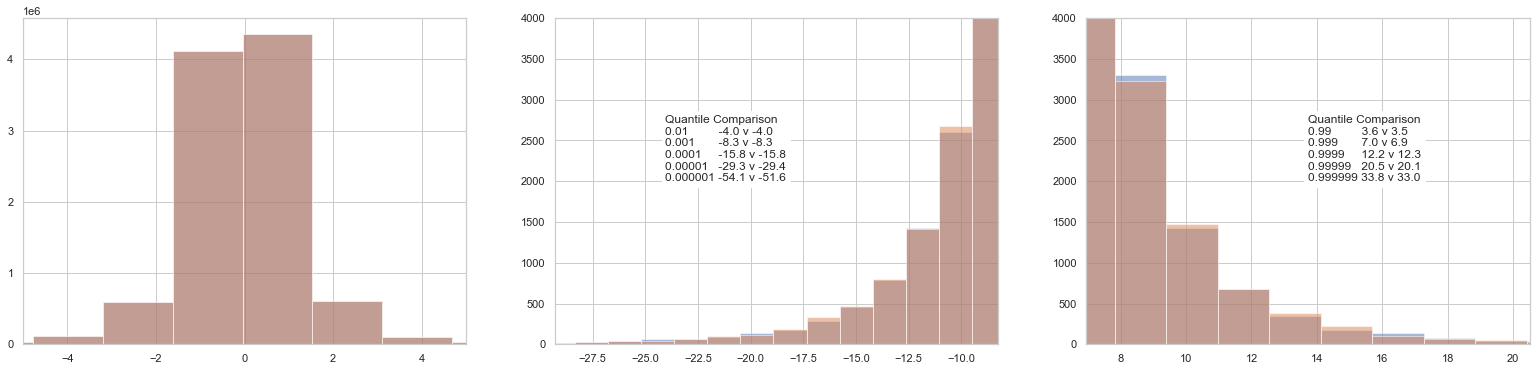

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(27,6))

_, bins, _ = ax1.hist(rv1, bins=100, alpha=.5)
_, _, _ = ax1.hist(rv2, bins=bins, alpha=.5)
ax1.set_xlim(-5,5)

_, bins, _ = ax2.hist(rv1, bins=100, alpha=.5)
_, _, _ = ax2.hist(rv2, bins=bins, alpha=.5)

l_crit = 1/np.logspace(2,6,5)
r_crit = 1 - l_crit

s1_qs, s2_qs = np.quantile(rv1, l_crit), np.quantile(rv2, l_crit)

txt = 'Quantile Comparison'
i = 0
for crit, s1q, s2q in zip(l_crit, s1_qs, s2_qs):
    i += 1
    txt += '\n'
    txt += f'{crit:.6f}'.rstrip("0") + ' '*(10-i*2) + f' {s1q:.1f} v {s2q:.1f}'

ax2.text(.25, .5, txt, transform=ax2.transAxes, bbox=dict(facecolor='w'))

ax2.set_xlim(s1_qs[3], s1_qs[1])
ax2.set_ylim(0,4000)

_, bins, _ = ax3.hist(rv1, bins=100, alpha=.5)
_, _, _ = ax3.hist(rv2, bins=bins, alpha=.5)

s1_qs, s2_qs = np.quantile(rv1, r_crit), np.quantile(rv2, r_crit)
txt = 'Quantile Comparison'
i = 0
for crit, s1q, s2q in zip(r_crit, s1_qs, s2_qs):
    i += 1
    txt += '\n'
    txt += f'{crit:.6f}'.rstrip("0") + ' '*(10-i*2) + f' {s1q:.1f} v {s2q:.1f}'

ax3.text(.5, .5, txt, transform=ax3.transAxes, bbox=dict(facecolor='w'))

ax3.set_xlim(s1_qs[1], s1_qs[3])
ax3.set_ylim(0,4000)

plt.show()

For convenience going forward, we will scale the PhatNet `mu` and `std` parameter outputs by 10.

We can confirm this with the Anderson-Darliing test for k-samples from `scipy`. The null hypothesis is that the two samples come from the same distribution.

In [15]:
phats_ad = scist.anderson_ksamp((
    rv1*10,
    rv2
))
phats_ad

<ipython-input-15-6e88e594027a>:1: UserWarning: p-value floored: true value smaller than 0.001
  phats_ad = scist.anderson_ksamp((


Anderson_ksampResult(statistic=2329284.4693649784, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

Per the result, we cannot reject that the two samples come from the same distribution

#### Comparing Fit ####

We will compare the fit of the residuals to the Phat distribution with that of the Normal by first assessing quantiles.

In [16]:
phat = Phat(None, mu*10, std*10, l, r)

norm_params = scist.norm.fit(garch_resids.flatten())
normfit = scist.norm(*norm_params)

l_crit = 1/np.logspace(2,5,4)
r_crit = 1 - l_crit

l_act = np.quantile(garch_resids.flatten(), l_crit)
nl_act = [(garch_resids.flatten() < q).sum() for q in l_act]

df_lcrit = pd.DataFrame([
    nl_act,
    l_act,
    phat.ppf(l_crit), 
    normfit.ppf(l_crit),
], index=['# Obs', 'Acutal', 'Phat', 'Normal'], columns=l_crit).T

r_act = np.quantile(garch_resids.flatten(), r_crit)
nr_act = [(garch_resids.flatten() > q).sum() for q in r_act]
df_rcrit = pd.DataFrame([
    nr_act,
    r_act,
    phat.ppf(r_crit), 
    normfit.ppf(r_crit),
], index=['# Obs', 'Acutal', 'Phat', 'Normal'], columns=r_crit).T

df_crit = pd.concat((df_lcrit[::-1], df_rcrit))

df_crit

We can see the quantile values of the actual observations lie somewhere between the Phat and the Normal. The left tail of the Phat also exhibits better fit, to be expected given it has a larger tail index.

We can also check the Anderson-Darling k-sample test for both distributions.

In [19]:
norm_ad = scist.anderson_ksamp((
    garch_resids.flatten(), 
    normfit.rvs(size=1000000)/normfit.std()
))
phat_ad = scist.anderson_ksamp((
    garch_resids.flatten(),
    phat.rvs(size=1000000)
))

norm_ad, phat_ad

<ipython-input-19-71179a1384e5>:1: UserWarning: p-value floored: true value smaller than 0.001
  norm_ad = scist.anderson_ksamp((
<ipython-input-19-71179a1384e5>:5: UserWarning: p-value floored: true value smaller than 0.001
  phat_ad = scist.anderson_ksamp((


(Anderson_ksampResult(statistic=102.10291913734514, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001),
 Anderson_ksampResult(statistic=71.39528609977258, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001))

In [20]:
phat = Phat(None, mu*10, std*10, l, r)

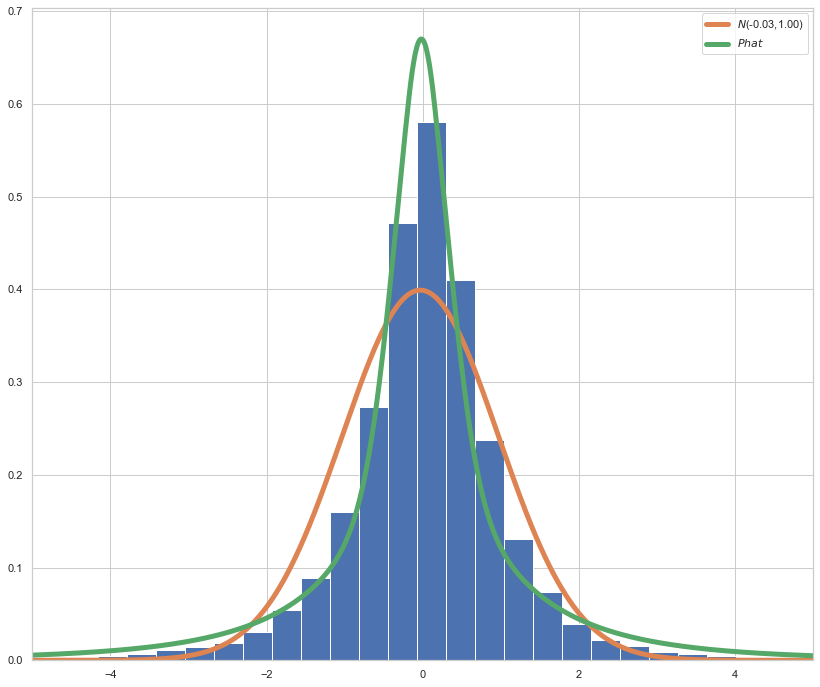

In [21]:
fig, ax = plt.subplots(1,1, figsize=(14,12))

plt.hist(sp_ret, bins=100, density=True)

x = np.linspace(-5, 5, 1000)
ax.plot(
    x, normfit.pdf(x), c='C1', lw=5,
    label=r'$N$'+f'({normfit.args[0]:.2f},{normfit.args[1]:.2f})')
ax.plot(
    x, phat.pdf(x), c='C2', lw=5,
    label=r'$Phat$'
)

ax.set_xlim(-5,5)

ax.legend()
plt.show()

We can see consistent with the quantile finds that the Phat performs better than the normal over the head and tail, but underperforms with respecect to the shoulder.

So daily return are very likely fat-tailed, but perhaps not as fat-tailed as the Phat distribution. One of 3 possibilities exist:

1. The distribution IS our Phat, however, larges numbers occur to often to provide sgnificance differnt Q tests.
2. come back

### Phatcast ###

Now we have enough to generate a GARCH forecast with Phat residuals. We will compare the forecast to the standard normal residuals visually, using 1-year and 10-year timeframes.

In [22]:
n = 10000
days = 252

mod = Garchcaster(
    data.raw.y.copy(), 
    arch11.conditional_volatility.values.copy(),
    arch11.resid.values.copy(),
    None,
    arch11.params.values,
    iters=n,
    periods=days,
)

In [23]:
res1 = mod.forecast(dist=phat)
res2 = mod.forecast()

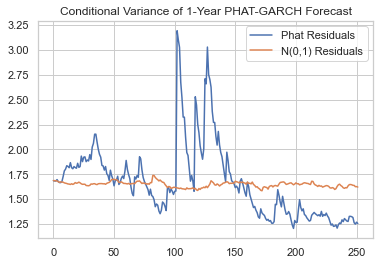

In [24]:
plt.plot((res1.vols**2).T.mean(axis=1), label='Phat Residuals')
plt.plot((res2.vols**2).T.mean(axis=1), label='N(0,1) Residuals')

plt.legend()
plt.title('Conditional Variance of 1-Year PHAT-GARCH Forecast')
plt.show()

Obviously, for the long-term forecasts, the Phat distribution creates a much more "natural" volatility with short, dramatic spikes, elevated levels of volatility, and prolong periods of sustained declining and low volatility.

Now for 10-years:

In [25]:
res3 = mod.forecast(dist=phat, periods=days*10)
res4 = mod.forecast(periods=days*10)

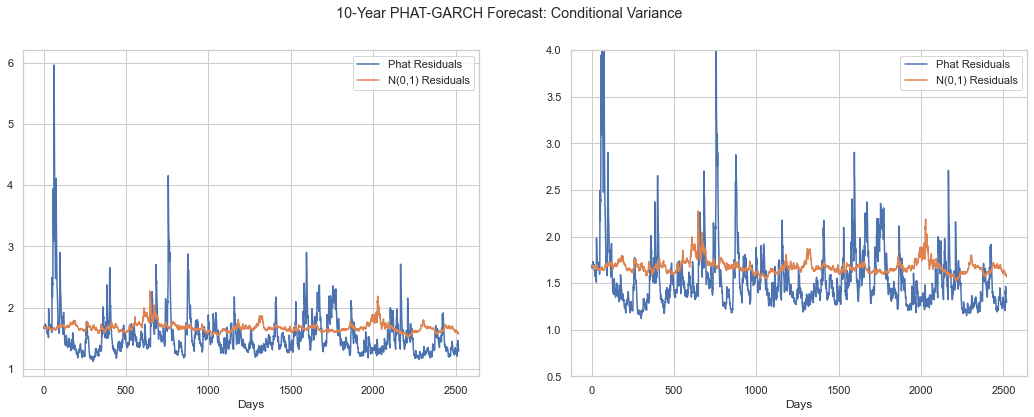

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot((res3.vols**2).T.mean(axis=1), label='Phat Residuals')
ax1.plot((res4.vols**2).T.mean(axis=1), label='N(0,1) Residuals')

ax2.plot((res3.vols**2).T.mean(axis=1), label='Phat Residuals')
ax2.plot((res4.vols**2).T.mean(axis=1), label='N(0,1) Residuals')
ax2.set_ylim(.5,4)

ax1.set_xlabel('Days')
ax2.set_xlabel('Days')
ax1.legend()
ax2.legend()
plt.suptitle('10-Year PHAT-GARCH Forecast: Conditional Variance')
plt.show()

We can see again from the above that the "natural" volatility process continues for many periods, well after the standard normal has found a stable range. The variance values above may seem dramatic but relative to the spikes seen in 2020 and 2008, they may even be conservative.

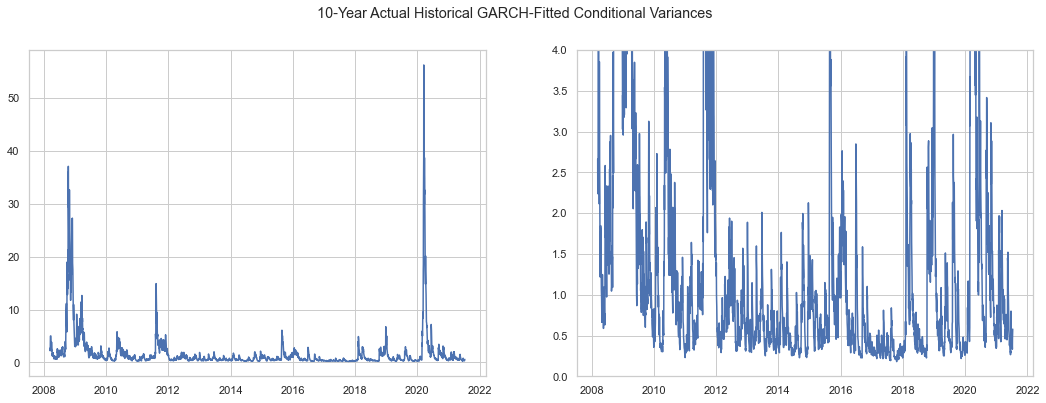

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(arch11.conditional_volatility**2)

ax2.plot(arch11.conditional_volatility**2)
ax2.set_ylim(0,4)

plt.suptitle('10-Year Actual Historical GARCH-Fitted Conditional Variances')
plt.show()

In the right-handed subplot we can see one major weakness of our approach: the conditional variance of the S&P500 over the last 15 years spent extended periods below 1x and was, in general, more volatility between the range of .5 and 2x than is produced by the Phat distribution.

This is a well-understood effect of ARCH models and has led to its various extentions over time: GARCH, IGARCH, TGARCH, EGARCH etc.

To address this in the future, we might consider:

1. Introducing the Phat distribution during the fit
2. Utilizing a truncated Phat distribution
3. Employing the other derivative Garch processes.

Still, despite this drawback, we clearly have evidenced of a more realistic process.

We can replicate this outcome in `arch` to confirm.

In [28]:
def custom_rng(phat):
    def _rng(size):
        shocks = phat.rvs(size=size)/phat.vol()
        return shocks
    return _rng

In [29]:
sim1 = arch11.forecast(
    horizon=days,
    simulations=n,
    rng=custom_rng(phat),
    method='simulation',
    reindex=False
)

sim2 = arch11.forecast(
    horizon=days,
    simulations=n,
    method='simulation',
    reindex=False
)

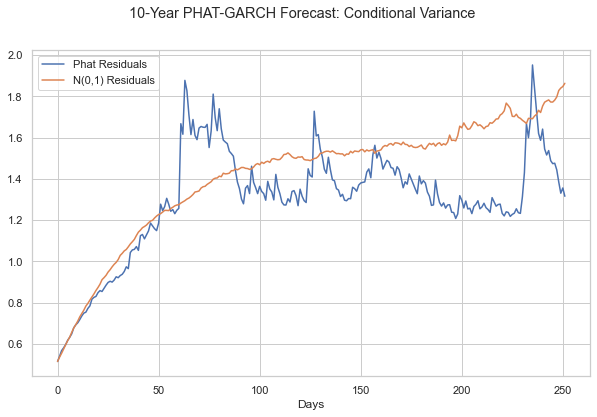

In [30]:
fig, ax1 = plt.subplots(1,1,figsize=(10,6))

ax1.plot(sim1.variance.values.T, label='Phat Residuals')
ax1.plot(sim2.variance.values.T, label='N(0,1) Residuals')

ax1.set_xlabel('Days')
ax1.legend()

plt.suptitle('10-Year PHAT-GARCH Forecast: Conditional Variance')
plt.show()

### 1-Year Price Forecast ###

Remember the above forecast ignored the ARMA portion of our fit. We will incorporate that this time and see the impact on the distribution of the index price one-year from now.

In [35]:
n = 10000
days = 252

mod = Garchcaster(
    data.raw.y.copy(), 
    arch11.conditional_volatility.values.copy(),
    arch11.resid.values.copy(),
    arma22.params(),
    arch11.params.values,
    iters=n,
    periods=days,
)
res = mod.forecast(dist=phat)

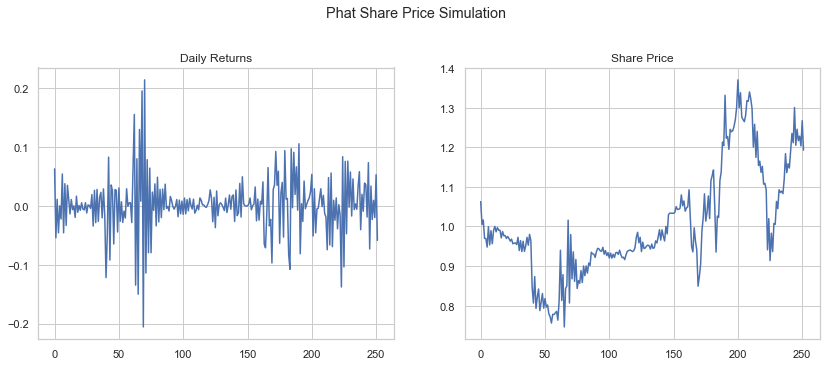

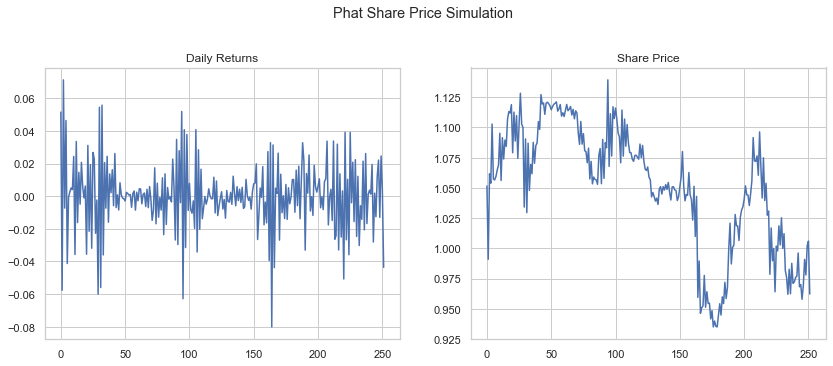

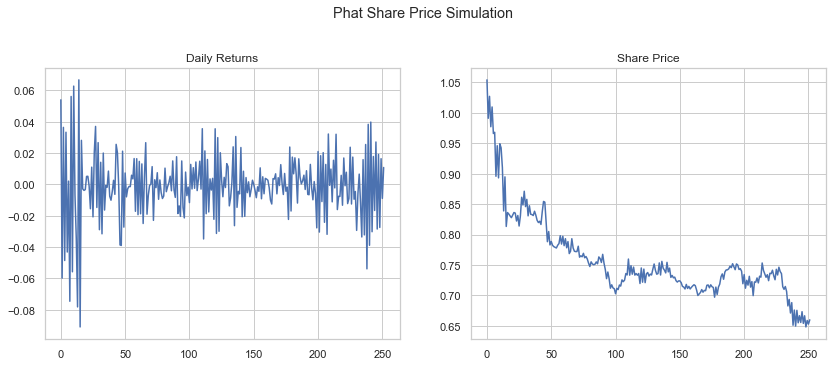

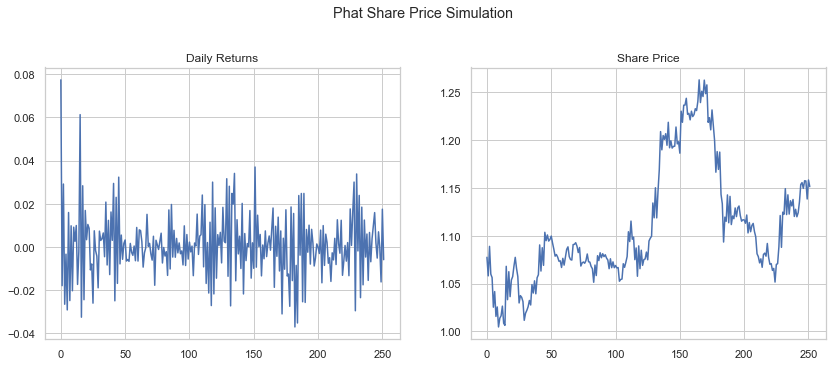

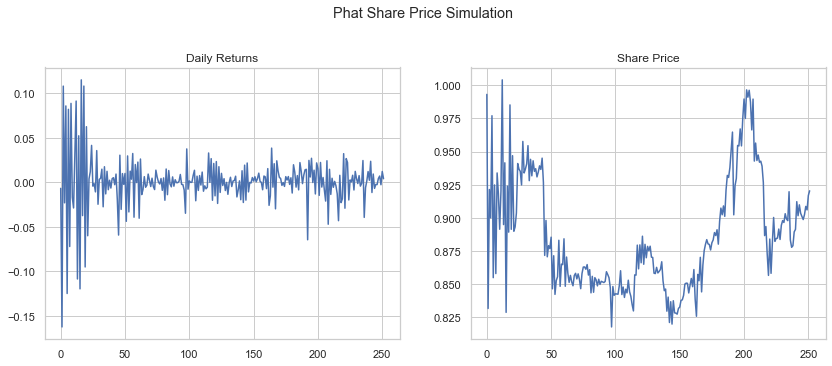

In [36]:
simmer = PriceSim(1,days=days, n=n)

for i in np.random.randint(0,40, size=5):
    simrets, _, axes = simmer.sim(rets=(1 + res.rets[i]/100), show_chart=True)

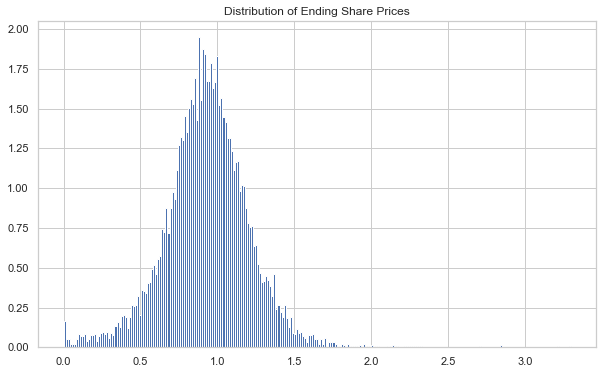

In [40]:
_, S, (ax, _) = simmer.sims(rets=1 + res.rets/100, show_chart=True)

# txt = 'Descriptive Statistics'
# j=0
# for i, val in pd.Series(S[:, -1]).describe().iteritems():
#     print (i, val)
#     j += 1
#     fmt = '{:,.2f}'.format(val) if val < 10 else '{:,.0f}'.format(val)
#     txt += '\n'
#     txt += f'{i.capitalize()}       ' + fmt
    
# ax.text(.5,.5,txt,transform=ax.transAxes, bbox=dict(fc='white'))

# logps = scist.lognorm.fit(S[:, -1])
# x = np.linspace(.25, 2, 1000)
# lnormfit = scist.lognorm.pdf(x, *logps)
# print (logps)
# ax.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

# ps = scist.norm.fit(S[:, -1])
# normfit = scist.norm.pdf(x, *ps)
# ax.plot(x, normfit, c='C3', label=r'$N$'+f'({ps[0]:.2f},{ps[1]:.2f})')

plt.show()

In [43]:
(S[:,-1] < 0).sum() / 10000

0.0016

Here we see the tail regions of a 1-year price forecast are *dramatically* larger, particularly in the fat tail where ~2% of simulations ended with a 70% decline. This amounts to about once every 50 years, which is perhaps a bit more aggressive than historical, as we have only one datapoint / timeframe where such a decline occured (the Great Crash).

Again, incorporating the Phat into the fitting process should alleviate this to some degree. A truncated Pareto might also reduce.

## PHAT-ARGARCH ##

In an effort to show the whole process in a more condensed fashion, we will fit and forecast using the `arch` packages internal `AR-GARCH` fitting model, which should provide more efficient and accurate fit for both `AR` and `GARCH` parameters, though it might ignore some mean correlation.

In [44]:
ar = arch.univariate.ARX(sp_ret, lags=[1,2])
ar.volatility = arch.univariate.GARCH(p=1, q=1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                  Close   R-squared:                      -0.007
Mean Model:                        AR   Adj. R-squared:                 -0.007
Vol Model:                      GARCH   Log-Likelihood:               -31003.4
Distribution:                  Normal   AIC:                           62018.8
Method:            Maximum Likelihood   BIC:                           62067.2
                                        No. Observations:                23494
Date:                Sat, Jul 17 2021   Df Residuals:                    23491
Time:                        04:25:50   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0505  5.709e-03      8.844  9.215e-

In [45]:
data = DataSplit(np.zeros(res.std_resid.size-2), res.std_resid.values[2:]/10)

left = data.raw.y[data.raw.y < data.raw.y.mean()]
left = np.sort(-left)[::-1]

right = data.raw.y[data.raw.y > data.raw.y.mean()]
right = np.sort(right)[::-1]

np.seterr(all='ignore')
shl = np.zeros(10)
shr = np.zeros(10)
for i in trange(10):
    shl[i] = dbl_bs(left, t=.5, r=500, style='hill', A_type='dani')
    shr[i] = dbl_bs(right, t=.5, r=500, style='hill', A_type='dani')
    
print (shl.mean(), shr.mean())

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
nnet = PhatNet(neurons=1)

metrics = [
    PhatMetric('shape_left'),
    PhatMetric('shape_right'),
    PhatMetric('mean_left'),
    PhatMetric('std_left'),  
]
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
nnet.compile(loss=PhatLoss(shl.mean(),shr.mean()), optimizer=optimizer, metrics=metrics)

history = nnet.fit(
    data.train, 
    epochs=100,
    validation_data=data.test,
    logdir=f"logs/ar_garch_strip_{dt.now().strftime('%Y-%m-%d-%H-%M')}"
)

Epoch 1/100
595/595 [==============================] - 5s 4ms/step - loss: 0.3663 - shape_left: 0.8559 - shape_right: 1.0847 - mean_left: -0.0035 - std_left: 0.4644 - val_loss: 0.2370 - val_shape_left: 0.8563 - val_shape_right: 1.0855 - val_mean_left: -0.0031 - val_std_left: 0.4640
Epoch 2/100
595/595 [==============================] - 1s 2ms/step - loss: 0.1357 - shape_left: 1.0410 - shape_right: 1.5455 - mean_left: 1.6751e-04 - std_left: 0.2534 - val_loss: 0.0458 - val_shape_left: 1.0412 - val_shape_right: 1.5461 - val_mean_left: 7.7603e-04 - val_std_left: 0.2531
Epoch 3/100
595/595 [==============================] - 1s 2ms/step - loss: -0.0222 - shape_left: 0.9838 - shape_right: 1.7240 - mean_left: 0.0044 - std_left: 0.1233 - val_loss: -0.0872 - val_shape_left: 0.9833 - val_shape_right: 1.7238 - val_mean_left: 0.0052 - val_std_left: 0.1231
Epoch 4/100
595/595 [==============================] - 1s 2ms/step - loss: -0.1475 - shape_left: 0.5781 - shape_right: 1.2680 - mean_left: 0.0080

In [47]:
mu, std, l, r = nnet.predicted_params(return_type='values')
phat = Phat(None, mu*10, std*10, l, r)

In [48]:
phat = Phat(None, mu*10, std*10, l, r)

n = 100000
days = 252

mod = Garchcaster(
    data.raw.y.copy(), 
    arch11.conditional_volatility.values.copy(),
    arch11.resid.values.copy(),
    res.params[:3].values,
    res.params[[0,3,4,5]].values,
    iters=n,
    periods=days,
    order=(2,0,1,1),
)
arres = mod.forecast(dist=phat)

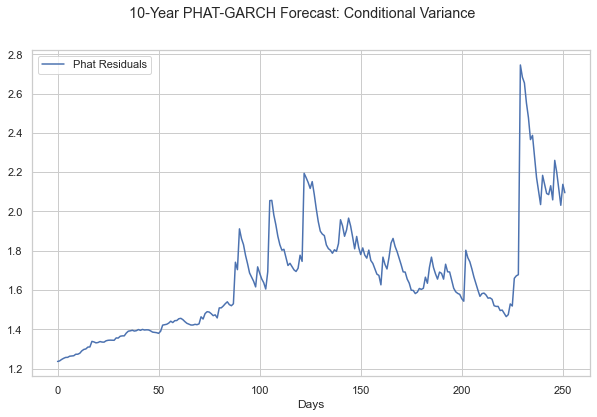

In [49]:
fig, ax1 = plt.subplots(1,1,figsize=(10,6))

ax1.plot((arres.vols**2).mean(axis=0).T, label='Phat Residuals')

ax1.set_xlabel('Days')
ax1.legend()

plt.suptitle('10-Year PHAT-GARCH Forecast: Conditional Variance')
plt.show()

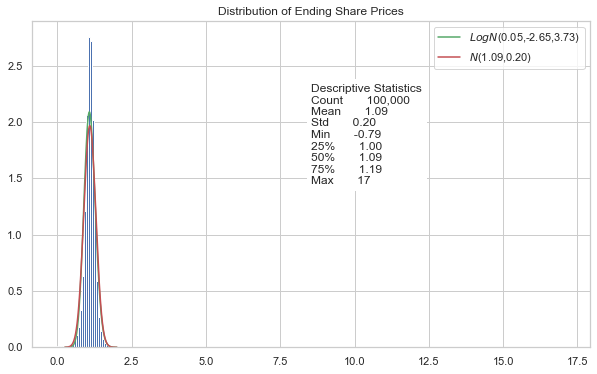

In [50]:
_, S, (ax, _) = simmer.sims(rets=1 + arres.rets/100, show_chart=True)

txt = 'Descriptive Statistics'
j=0
for i, val in pd.Series(S[:, -1]).describe().iteritems():
    j += 1
    fmt = '{:,.2f}'.format(val) if val < 10 else '{:,.0f}'.format(val)
    txt += '\n'
    txt += f'{i.capitalize()}       ' + fmt
ax.text(.5,.5,txt,transform=ax.transAxes, bbox=dict(fc='white'))

logps = scist.lognorm.fit(S[:, -1])
x = np.linspace(.25, 2, 1000)
lnormfit = scist.lognorm.pdf(x, *logps)
ax.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ps = scist.norm.fit(S[:, -1])
normfit = scist.norm.pdf(x, *ps)
ax.plot(x, normfit, c='C3', label=r'$N$'+f'({ps[0]:.2f},{ps[1]:.2f})')

ax.legend()
plt.show()

plt.show()

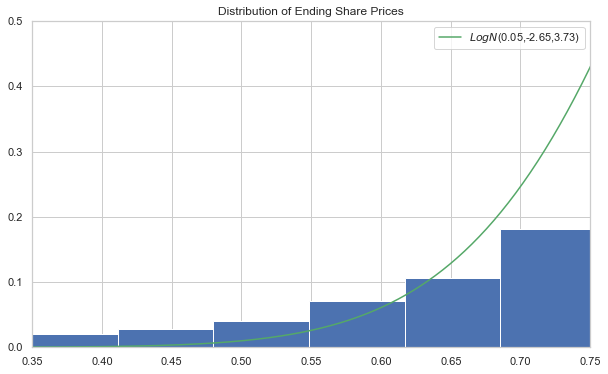

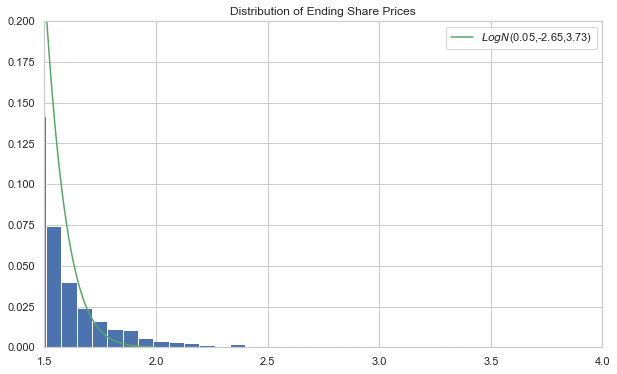

In [51]:
_, S, (ax1, _) = simmer.sims(rets=1 + arres.rets/100, show_chart=True)

logps = scist.lognorm.fit(S[:, -1])
x = np.linspace(.25, 2, 1000)
lnormfit = scist.lognorm.pdf(x, *logps)
ax1.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ax1.set_xlim(.35,.75)
ax1.set_ylim(0,.5)

ax1.legend()

_, S, (ax2, _) = simmer.sims(rets=1 + arres.rets/100, show_chart=True)

logps = scist.lognorm.fit(S[:, -1])
x = np.linspace(.25, 2, 1000)
lnormfit = scist.lognorm.pdf(x, *logps)
ax2.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ax2.set_xlim(1.5,4)
ax2.set_ylim(0,.2)

ax2.legend()

plt.show()

In [52]:
arres2 = mod.forecast(dist=phat, periods=252*5)

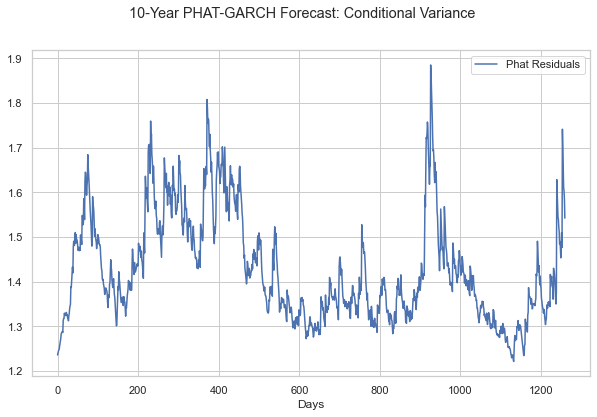

In [53]:
fig, ax1 = plt.subplots(1,1,figsize=(10,6))

ax1.plot((arres2.vols**2).mean(axis=0).T, label='Phat Residuals')

ax1.set_xlabel('Days')
ax1.legend()

plt.suptitle('10-Year PHAT-GARCH Forecast: Conditional Variance')
plt.show()

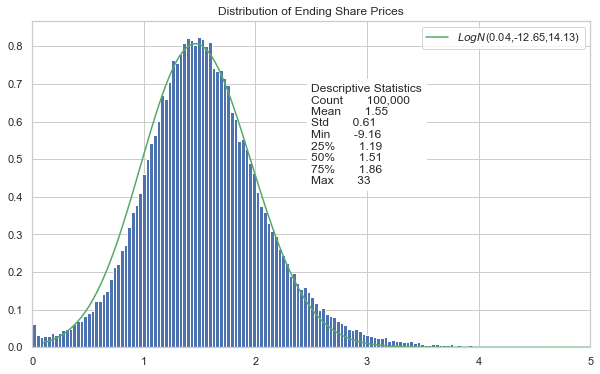

In [101]:
_, S, (ax, _) = simmer.sims(rets=1 + arres2.rets/100, show_chart=True, bins=1000)

txt = 'Descriptive Statistics'
j=0
for i, val in pd.Series(S[:, -1]).describe().iteritems():
    j += 1
    fmt = '{:,.2f}'.format(val) if val < 10 else '{:,.0f}'.format(val)
    txt += '\n'
    txt += f'{i.capitalize()}       ' + fmt
ax.text(.5,.5,txt,transform=ax.transAxes, bbox=dict(fc='white'))

logps = scist.lognorm.fit(S[:, -1])
x = np.linspace(.1, 10, 1000)
logps = list(logps)
logps[0] = .035
logps[1] = -12.65
# logps[2] = 13
lnormfit = scist.lognorm.pdf(x, *logps)
ax.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

# ps = scist.norm.fit(S[:, -1])
# normfit = scist.norm.pdf(x, *ps)
# ax.plot(x, normfit, c='C3', label=r'$N$'+f'({ps[0]:.2f},{ps[1]:.2f})')

# ax.set_xlim(2,5)
ax.set_xlim(0,5)
ax.legend()
plt.show()

plt.show()

### Fit GARCH w Student's T ###

In [154]:
from arch.univariate import StudentsT

tres = arch.univariate.ARX(sp_ret, lags=[1,2])
tres.distribution = StudentsT()

tres.volatility = arch.univariate.GARCH(p=1, q=1)
res3 = tres.fit(update_freq=0, disp="off")
print(res3.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                        Close   R-squared:                      -0.006
Mean Model:                              AR   Adj. R-squared:                 -0.006
Vol Model:                            GARCH   Log-Likelihood:               -30170.5
Distribution:      Standardized Student's t   AIC:                           60355.1
Method:                  Maximum Likelihood   BIC:                           60411.5
                                              No. Observations:                23494
Date:                      Sat, Jul 17 2021   Df Residuals:                    23491
Time:                              05:16:46   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

In [155]:
sim3 = res3.forecast(
    horizon=days,
    simulations=n,
    method='simulation',
    reindex=False
)

In [156]:
values = sim3.simulations.values[0]

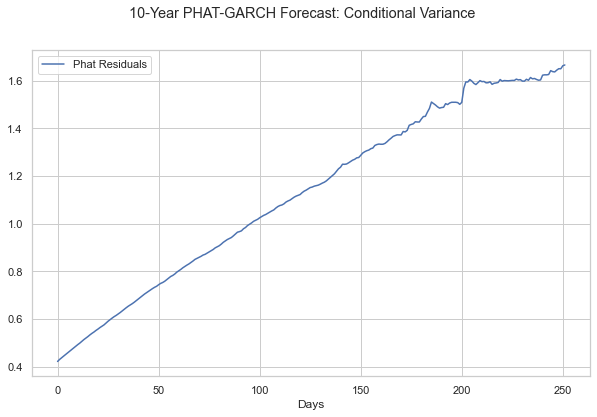

In [157]:
fig, ax1 = plt.subplots(1,1,figsize=(10,6))

ax1.plot((sim3.variance).T.values, label='Phat Residuals')

ax1.set_xlabel('Days')
ax1.legend()

plt.suptitle('10-Year PHAT-GARCH Forecast: Conditional Variance')
plt.show()

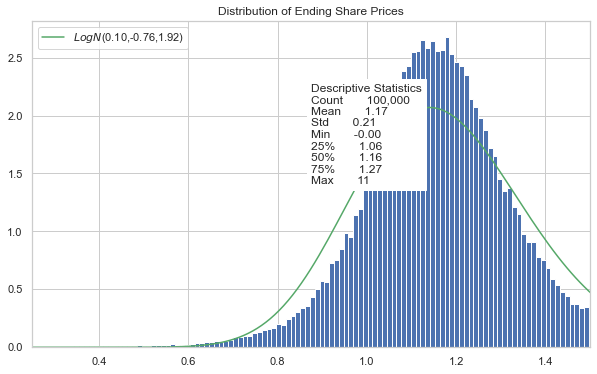

In [158]:
_, S, (ax, _) = simmer.sims(rets=1 + values/100, show_chart=True, bins=1000)

txt = 'Descriptive Statistics'
j=0
for i, val in pd.Series(S[:, -1]).describe().iteritems():
    j += 1
    fmt = '{:,.2f}'.format(val) if val < 10 else '{:,.0f}'.format(val)
    txt += '\n'
    txt += f'{i.capitalize()}       ' + fmt
ax.text(.5,.5,txt,transform=ax.transAxes, bbox=dict(fc='white'))

logps = scist.lognorm.fit(S[:, -1])
x = np.linspace(.1, 10, 1000)
logps = list(logps)
# logps[0] = .035
# logps[1] = -12.65
# logps[2] = 13
lnormfit = scist.lognorm.pdf(x, *logps)
ax.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ax.set_xlim(.25,1.5)
ax.legend()
plt.show()

plt.show()

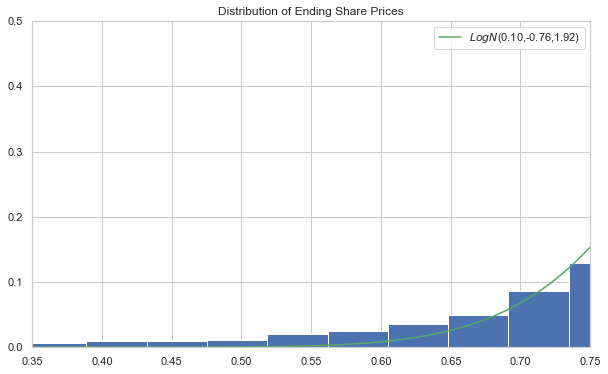

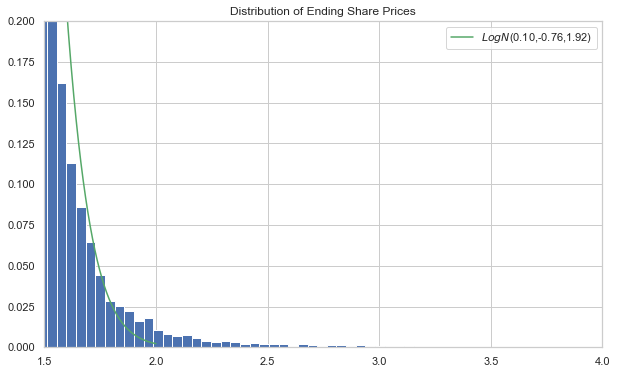

In [159]:
_, S, (ax1, _) = simmer.sims(rets=1 + values/100, show_chart=True)

logps = scist.lognorm.fit(S[:, -1])
x = np.linspace(.25, 2, 1000)
lnormfit = scist.lognorm.pdf(x, *logps)
ax1.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ax1.set_xlim(.35,.75)
ax1.set_ylim(0,.5)

ax1.legend()

_, S, (ax2, _) = simmer.sims(rets=1 + values/100, show_chart=True)

logps = scist.lognorm.fit(S[:, -1])
x = np.linspace(.25, 2, 1000)
lnormfit = scist.lognorm.pdf(x, *logps)
ax2.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ax2.set_xlim(1.5,4)
ax2.set_ylim(0,.2)

ax2.legend()

plt.show()

In [273]:
data = DataSplit(np.zeros(res3.std_resid.size-2), res3.std_resid.values[2:]/10)

In [274]:
# data = DataSplit(np.zeros(25000), scist.t.rvs(df=5, size=25000)/10)

left = data.raw.y[data.raw.y < data.raw.y.mean()]
left = np.sort(-left)[::-1]

right = data.raw.y[data.raw.y > data.raw.y.mean()]
right = np.sort(right)[::-1]

np.seterr(all='ignore')
shl = np.zeros(10)
shr = np.zeros(10)
for i in trange(10):
    shl[i] = dbl_bs(left, t=.5, r=500, style='hill', A_type='dani')
    shr[i] = dbl_bs(right, t=.5, r=500, style='hill', A_type='dani')
    
print (shl.mean(), shr.mean())

  0%|          | 0/10 [00:00<?, ?it/s]

0.26508013714342027 0.2033294528051936


In [275]:
from analysis.options.pricing.learn.phatnet import PhatNet, PhatLoss, PhatMetric

In [276]:
nnet = PhatNet(neurons=1)

metrics = [
    PhatMetric('shape_left'),
    PhatMetric('shape_right'),
    PhatMetric('mean_left'),
    PhatMetric('std_left'),  
]
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
nnet.compile(loss=PhatLoss(shl.mean(),shr.mean()), optimizer=optimizer, metrics=metrics)

history = nnet.fit(
    data.train, 
    epochs=100,
    validation_data=data.test,
    logdir=f"logs/studetns_garch_strip_{dt.now().strftime('%Y-%m-%d-%H-%M')}"
)

Epoch 1/100
595/595 [==============================] - 5s 4ms/step - loss: 0.3107 - shape_left: 0.8430 - shape_right: 1.1109 - mean_left: -0.0191 - std_left: 0.3487 - val_loss: 0.1469 - val_shape_left: 0.8432 - val_shape_right: 1.1117 - val_mean_left: -0.0188 - val_std_left: 0.3482
Epoch 2/100
595/595 [==============================] - 2s 3ms/step - loss: 0.0313 - shape_left: 0.8828 - shape_right: 1.4318 - mean_left: -0.0014 - std_left: 0.1488 - val_loss: -0.0676 - val_shape_left: 0.8825 - val_shape_right: 1.4318 - val_mean_left: -7.4852e-04 - val_std_left: 0.1486
Epoch 3/100
595/595 [==============================] - 1s 2ms/step - loss: -0.1413 - shape_left: 0.5935 - shape_right: 1.1850 - mean_left: 0.0050 - std_left: 0.0713 - val_loss: -0.2241 - val_shape_left: 0.5929 - val_shape_right: 1.1840 - val_mean_left: 0.0057 - val_std_left: 0.0713
Epoch 4/100
595/595 [==============================] - 1s 2ms/step - loss: -0.3183 - shape_left: 0.3276 - shape_right: 0.6680 - mean_left: 0.0059 

In [277]:
mu, std, l, r = nnet.predicted_params(return_type='values')
phat1 = Phat(None, mu*10, std*10, l, r)

In [278]:
phat1.vol()

1.3595493932842457

In [279]:
t_params = scist.t.fit(data.raw.y*10)
tfit = scist.t(*t_params)
norm_params = scist.norm.fit(data.raw.y*10)
normfit = scist.t(*norm_params)

In [280]:
l_crit = 1/np.logspace(2,5,4)
r_crit = 1 - l_crit

l_act = np.quantile(data.raw.y*10, l_crit)
nl_act = [(data.raw.y*10 < q).sum() for q in l_act]

df_lcrit = pd.DataFrame([
    nl_act,
    l_act,
    phat1.ppf(l_crit), 
    tfit.ppf(l_crit),
    normfit.ppf(l_crit),    
], index=['# Obs', 'Acutal', 'Phat', 'T', 'Normal'], columns=l_crit).T

r_act = np.quantile(data.raw.y*10, r_crit)
nr_act = [(data.raw.y*10 > q).sum() for q in r_act]
df_rcrit = pd.DataFrame([
    nr_act,
    r_act,
    phat1.ppf(r_crit), 
    tfit.ppf(r_crit),
    normfit.ppf(r_crit),    
], index=['# Obs', 'Acutal', 'Phat', 'T', 'Normal'], columns=r_crit).T

df_crit = pd.concat((df_lcrit[::-1], df_rcrit))

df_crit

,# Obs,Acutal,Phat,T,Normal
0.00001,1.0,-10.989057,-31.560691,-10.280931,NaN
0.00010,3.0,-9.263319,-16.808537,-6.761200,NaN
0.00100,24.0,-4.684516,-8.617395,-4.334129,NaN
0.01000,235.0,-2.728336,-4.023870,-2.591573,NaN
0.99000,235.0,2.281695,3.527372,2.556437,NaN
0.99900,24.0,3.609201,6.872254,4.298993,NaN
0.99990,3.0,5.355809,12.044772,6.726064,NaN
0.99999,1.0,6.761321,20.130666,10.245795,NaN


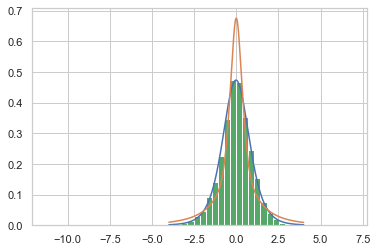

In [286]:
x = np.linspace(-4,4, 1000)
plt.plot(x, tfit.pdf(x))
plt.plot(x, phat1.pdf(x))
counts, bins, _ = plt.hist(data.raw.y*10, bins=50, density=True)

plt.show()

## CAVEATS ##

While GARCH models have been shown to outperform constant volatility models, [stochastic volatility](https://joshuachan.org/papers/energy_GARCH_SV.pdf) has become more popular recently and will be explored at a future date.
